# Wildfires

Create directories (if they don't exist already)

In [ ]:
import os

print("Current working directory: " + os.getcwd())
for dir_name in ["wind_interp", "fire_grid, lag", "correlation"]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

Load the fire and wind data saved in csv file. The fire data is every 10 mins.
The wind data is every 60 mins, and interpolated to 10 mins.

Save the generated fire data in 2D matrices under fire_grid directory
Save the generated wind data in 2D matrices under wind_interp directory.

# Preprocessing

In [ ]:
FIRE_DF_PATH = "fire_df_08_05.csv"
WIND_DF_PATH = "wind_df_08_05.csv"

from timeinterp import *
time_interp(data_path=WIND_DF_PATH)

from preprocessing import *
preprocess(data_path=FIRE_DF_PATH)

from cross_correlation import *


In [ ]:
import pandas as pd

fire = pd.read_csv("fire_df_08_01.csv")
wind = pd.read_csv("wind_df_08_01.csv")

for df in [fire, wind]:
    df['datetime'] = df['datetime'].apply(lambda time: pd.to_datetime(time).replace(second=0, microsecond=0))
    df[['longitude', 'latitude']] = df[['longitude', 'latitude']].round(5)

merge = pd.merge(fire, wind, how="outer", on=["datetime", "longitude", "latitude"])
merge.to_csv("merge.csv", index=False)

In [ ]:
import pandas as pd

fire = pd.read_csv("fire_df_08_01.csv")
wind = pd.read_csv("wind_df_08_01.csv")

for df in [fire, wind]:
    df['datetime'] = df['datetime'].apply(lambda time: pd.to_datetime(time).replace(second=0, microsecond=0))
    df[['longitude', 'latitude']] = df[['longitude', 'latitude']].round(5)

merge = pd.merge_ordered(fire, wind, how="left", on=['datetime', 'longitude', 'latitude'], fill_method='ffill')
merge.to_csv("merge.csv", index=False)

# Format data

In [12]:
import pandas as pd
import numpy as np

def process_fire(row):
    return np.nan_to_num(np.array(row))

merge = pd.read_csv("merge.csv")
merge = merge.sort_values(['longitude', 'latitude'])
grouped = merge.groupby('datetime')

wind = grouped['speed'].apply(np.array).to_list()
fire = np.array(grouped['Power'].apply(process_fire).to_list())

# Define and train model

In [13]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).float()
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


outputs = labels = None
losses = []
    
def train(model, train_loader, criterion, optimizer, num_epochs):
    global outputs, labels, losses
    losses = []
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        losses.append(total_loss)

        # Print the average loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

In [16]:
from torch.utils.data import DataLoader
import numpy as np

data = np.hstack((fire, wind))
print(data.shape)

epochs = 5
ds = CustomDataset(data[:-1], fire[1:])
dl = DataLoader(ds, batch_size=1, shuffle=True)
mlp = MLP(data.shape[1], 5000, data.shape[1] // 2)
train(mlp, dl, nn.L1Loss(), optim.SGD(mlp.parameters(), lr=0.01), epochs)

(24, 6160)
Epoch [1/5], Loss: 28.627253449481465
Epoch [2/5], Loss: 22.157976109048594
Epoch [3/5], Loss: 21.685259984887164
Epoch [4/5], Loss: 21.66588891070822
Epoch [5/5], Loss: 21.665816099747367


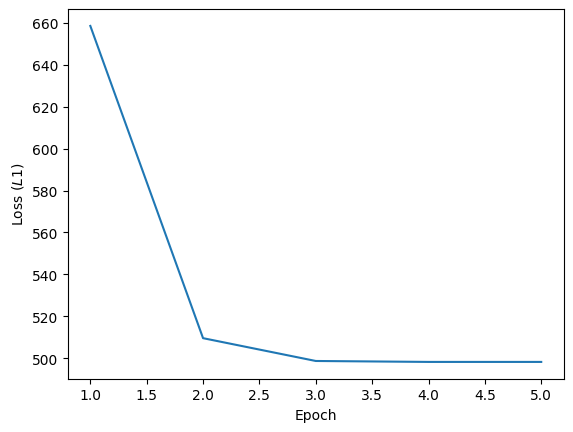

In [18]:
from matplotlib import pyplot as plt

def plot_loss(arr):
    plt.plot(range(1, len(arr)+1), arr)
    plt.xlabel("Epoch")
    plt.ylabel("Loss ($L1$)")
    plt.show()
    
plot_loss(losses)